In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')



<font size="6"><b>Regression Examples</b></font>

Table of Contents
<div id="toc"></div>


# 1. De-noising Signal

We start with a signal represented by a vector $x \in \mathbb{R}^n$. The coefficients $x_i$ correspond to the value of some function of time, evaluated (or _sampled_, in the language of signal processing) at evenly spaced points. It is usually assumed that the signal does not vary too rapidly, which means that usually, we have $x_i \approx x_{i+1}$.

Suppose we have a signal $x$, which does not vary too rapidly and that $x$ is corrupted by some small, rapidly varying noise $v$,
i.e. $x_{cor} = x + \upsilon$. 

Then if we want to reconstruct $x$ from $x_{cor}$ we should solve (with $\hat{x}$ as the parameter)

$$ \text{minimize} \quad \lVert \hat{x} - x_{cor}\rVert_2 + \lambda\sum_{i=1}^{n-1}(x_{i+1}-x_i)^2 $$

where the parameter $\lambda$ controls the ''smoothnes'' of $\hat{x}$.

Source:
- Boyd & Vandenberghe's book "[Convex Optimization](http://stanford.edu/~boyd/cvxbook/)"
- http://cvxr.com/cvx/examples/ (Figures 6.8-6.10: Quadratic smoothing)
- Week 4 of Linear and Integer Programming by [Coursera](https://www.coursera.org/) of Univ. of Colorado

Populating the interactive namespace from numpy and matplotlib


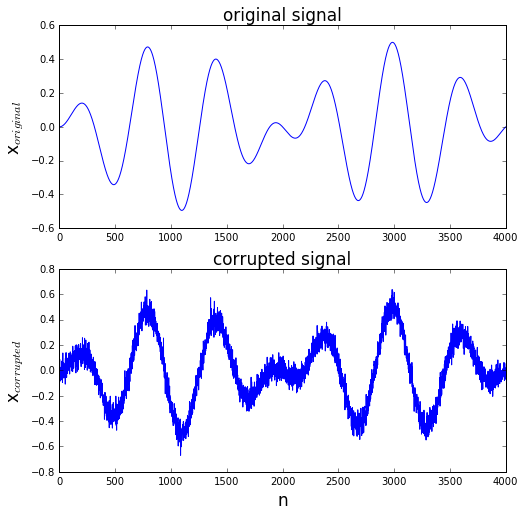

In [2]:
%matplotlib inline

n = 4000
t = [t_cont for t_cont in range(0,n)]
t = np.array(t)
exact = 0.5*np.sin((2*np.pi/n)*t)*(np.sin(0.01*t))
corrupt = exact + 0.05 * np.random.randn(exact.shape[0])


%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)

plt.subplot(2,1,1)
plt.plot(t,exact)
plt.title('original signal' , fontsize = 17)
plt.ylabel('x$_{original}$', fontsize = 17)

plt.subplot(2,1,2)
plt.plot(t, corrupt)
plt.ylabel('x$_{corrupted}$', fontsize = 17)
plt.xlabel('n', fontsize = 17)
plt.title('corrupted signal', fontsize = 17)
plt.show()

## 1.1. Transform de-noising in time into an optimization problem

<br>
$$\large \min\limits_{X}\;\left\{\underbrace{\lVert(X - X_{cor})\rVert^2_{2}}_{\text{how much } x \text{ deviates from }x_{cor}} + \mu \underbrace{\sum_{k = 1}^{n-1}(x_{k+1}-x_{k})^2}_{\text{penalize rapid changes of } X}\right\}$$

<br>

1) $\min\limits_{X}\;\lVert(X - X_{cor})\rVert^2_{2}$: $\quad$ How much $X$ deviates from $X_{cor}$

2) $\mu\sum\limits_{k = 1}^{n-1}(x_{k+1}-x_{k})^2$: $\quad$ penalize rapid changes of $X$
    
3) $\mu$ : to adjust the relative weight of 1) & 2)

$$X =
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{bmatrix}
$$

1) $X - X_{cor} = I_n X - X_{cor}$

2) $\sum\;(x_{k+1}-x_{k})^2 \implies$

$$(x_{2} - x_{1}) - 0 = 
\begin{bmatrix}
-1,&1,&0,&\cdots&0
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{bmatrix}-0
$$

$$(x_{3} - x_{2}) - 0 = 
\begin{bmatrix}
0,&-1,&1,&\cdots&0
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{bmatrix}-0
$$

$$
\vdots
$$

$$\implies
\left \Arrowvert \;
\begin{bmatrix}
-1&1&0&\cdots&0&0 \\
0&-1&1&\cdots&0&0 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
0&0&0&\cdots&-1&1
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{bmatrix}
-
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix} \;
\right\Arrowvert^2_{2}
$$

$$\hspace{3.2cm}D \quad\quad\quad\quad\quad\quad X \; \; - \; \; 0 $$

<br>

$$\begin{align*} \left\Vert I_n X-X_{cor}\big\Vert^2_{2} + \mu\big\Vert DX-0\right\Vert^2_{2}
& = \big\Vert Ax-b\big\Vert^2_{2} \\
& = \Bigg\Vert 
\begin{bmatrix}
I_n\\
\sqrt{\mu}D
\end{bmatrix}
X-
\begin{bmatrix}
X_{cor}\\
0
\end{bmatrix}
\Bigg\Vert^2_{2}
\end{align*}$$

$$ \text{where} \; 
A =  
\begin{bmatrix}
I_n\\
\sqrt{\mu}D
\end{bmatrix},\quad
b = 
\begin{bmatrix}
X_{cor}\\
0
\end{bmatrix}
$$


- Then, plug $A$, $b$ into Matlab with `cvx` toolbox to numerically solve

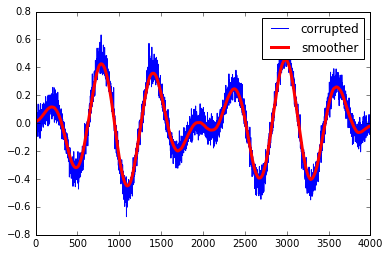

In [3]:
%matplotlib inline

n=4000
D = np.zeros((n-1, n))
D[:,0:n-1] = -np.eye(n-1)
D[:,1:n] = D[:,1:n+1] + np.eye(n-1)

mu = 1000

A = np.concatenate((np.eye(n), np.sqrt(mu)*D), 0)
b = np.concatenate((corrupt, np.zeros((n-1, ))), 0)

sol = np.linalg.inv(A.transpose().dot(A)).dot(A.transpose()).dot(b)

plt.plot(t, corrupt)
plt.plot(t, sol, 'r', linewidth = 3)
plt.legend(['corrupted', 'smoother'], loc = 1)

## 1.2. with different $\mu$'s (see how $\mu$ affects smoothing results)


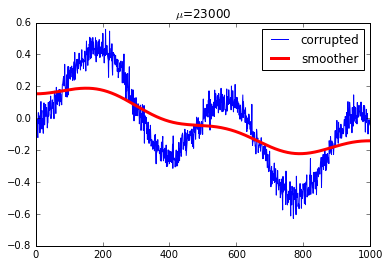

In [4]:
%matplotlib inline

n = 1000

t = [t_x for t_x in range(0,n)]
t = np.array(t)
exact = 0.5*np.sin((2*np.pi/n)*t)*(np.sin(0.01*t))
corrupt = exact + 0.05 * np.random.randn(exact.shape[0])

D = np.zeros((n-1, n))
D[:,0:n-1] = -np.eye(n-1)
D[:,1:n] = D[:,1:n+1] + np.eye(n-1)

def smooth_plot(mu = 1000):
    A = np.concatenate((np.eye(n), np.sqrt(mu)*D), 0)
   
    b = np.concatenate((corrupt, np.zeros((n-1, ))), 0)

    sol = np.linalg.inv(A.transpose().dot(A)).dot(A.transpose()).dot(b)

    plt.plot(t, corrupt)
    plt.plot(t, sol, 'r', linewidth = 3)
    plt.legend(['corrupted', 'smoother'], loc = 1)
    title = '=%s' % str(mu)
    plt.title('$\mu$' + title)
    plt.show()
from IPython.html.widgets import interact
interact(smooth_plot, mu=[0, 100000, 500]);

## 1.3. use CVX
- CVX strongly encourages to eliminate quadratic forms - that is, functions like sum_square, sum(square(.)) or quad_form - whenever it is possible to construct equivalent models using norm instead

$$ \min\; \left\{ \lVert x-x_{cor}\rVert_2^2 + \mu \lVert Dx \rVert_2^2 \right\}$$

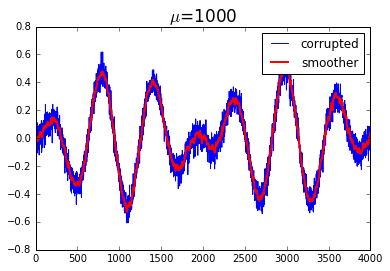

In [5]:
%matplotlib inline

n = 4000
t = [t_x for t_x in range(0,n)]
t = np.array(t)
exact = 0.5*np.sin((2*np.pi/n)*t)*(np.sin(0.01*t))
corrupt = exact + 0.05 * np.random.randn(exact.shape[0])

mu = 1000

x = cvx.Variable(n)
objective = cvx.Minimize(cvx.square(cvx.norm2(x-corrupt)) + mu*cvx.square(cvx.norm2(x[1:n]-x[0:n-1])))
constraint = []

Prob = cvx.Problem(objective, constraint)
result = Prob.solve()

plt.plot(t, corrupt)
plt.plot(t, x.value, 'r', linewidth = 2)
title = '=%s' % str(mu)
plt.title('$\mu$' + title, fontsize = 17)
plt.legend(['corrupted', 'smoother'], loc = 1)
plt.show()


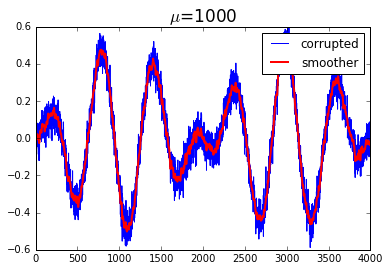

In [7]:
%matplotlib inline

n = 4000

t = [t_x for t_x in range(0,n)]
t = np.array(t)
exact = 0.5*np.sin((2*np.pi/n)*t)*(np.sin(0.01*t))
corrupt = exact + 0.05 * np.random.randn(exact.shape[0])

def smooth_plot_cvx(mu = 1000):
    x = cvx.Variable(n)
    objective = cvx.Minimize(cvx.square(cvx.norm2(x-corrupt)) + mu*cvx.square(cvx.norm2(x[1:n]-x[0:n-1])))
    constraint = []

    Prob = cvx.Problem(objective, constraint)
    result = Prob.solve()

    plt.plot(t, corrupt)
    plt.plot(t, x.value, 'r', linewidth = 2)
    title = '=%s' % str(mu)
    plt.title('$\mu$' + title, fontsize = 17)
    plt.legend(['corrupted', 'smoother'], loc = 1)
    plt.show()

from IPython.html.widgets import interact
interact(smooth_plot_cvx, mu=[0, 100000, 500]);

## 1.4. $L_2$ norm

$$ \min \; \left\{ \lVert x-x_{cor}\rVert_2 + \alpha \lVert Dx ~ \rVert_2 \right \}$$

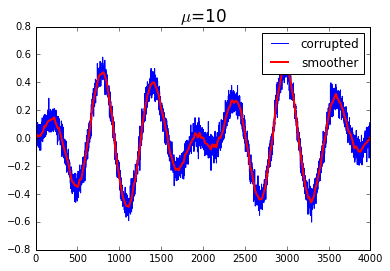

In [11]:
%matplotlib inline

n = 4000

t = [t_x for t_x in range(0,n)]
t = np.array(t)
exact = 0.5*np.sin((2*np.pi/n)*t)*(np.sin(0.01*t))
corrupt = exact + 0.05 * np.random.randn(exact.shape[0])

def smooth_plot_cvx(mu = 10):
    x = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm2(x-corrupt) + mu*cvx.norm2(x[1:n]-x[0:n-1]))
    constraint = []

    Prob = cvx.Problem(objective, constraint)
    result = Prob.solve()

    plt.plot(t, corrupt)
    plt.plot(t, x.value, 'r', linewidth = 2)
    title = '=%s' % str(mu)
    plt.title('$\mu$' + title, fontsize = 17)
    plt.legend(['corrupted', 'smoother'], loc = 1)
    plt.show()

from IPython.html.widgets import interact
interact(smooth_plot_cvx, mu=[0, 500, 10]);

## 1.5. $L_2$ norm with a constraint
$$\min \; \lVert Dx \rVert_2$$
 
$$ s.t. \quad \lVert x-x_{cor} \rVert_2 < \beta $$

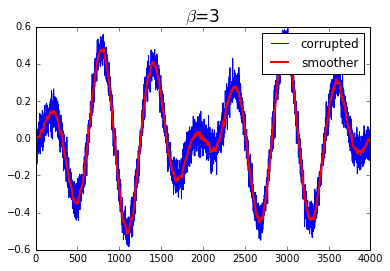

In [13]:
%matplotlib inline

n = 4000

t = [t_x for t_x in range(0,n)]
t = np.array(t)
exact = 0.5*np.sin((2*np.pi/n)*t)*(np.sin(0.01*t))
corrupt = exact + 0.05 * np.random.randn(exact.shape[0])

def smooth_plot_cvx_constant(beta = 3):
    x = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm2(x[1:n]-x[0:n-1]))
    constraint = [cvx.norm2(x-corrupt) <= beta]

    Prob = cvx.Problem(objective, constraint)
    result = Prob.solve()

    plt.plot(t, corrupt)
    plt.plot(t, x.value, 'r', linewidth = 2)
    title = '=%s' % str(beta)
    plt.title(r'$\beta$' + title, fontsize = 17)
    plt.legend(['corrupted', 'smoother'], loc = 1)
    plt.show()

from IPython.html.widgets import interact
interact(smooth_plot_cvx_constant, beta=[0, 20, 1]);

# 2. Signal with Sharp Transition + Noise

Suppose we have a signal $x$, which is mostly smooth, but has several rapid variations (or jumps). If we apply quadratic smoothing on this signal (see SMOOTHREC_CVX) then in order to remove the noise we will not be able to preserve the signal's sharp transitions.


- First, apply the same method that we used for smoothing signals before
- known as a _total variation problem_
- Source:
    - Chapter 6.3 from Boyd & Vandenberghe's book "[Convex Optimization](http://stanford.edu/~boyd/cvxbook/)"
    - m files of [total variation reconstruction](http://cvxr.com/cvx/examples/cvxbook/Ch06_approx_fitting/html/tv_cvx.html)


Populating the interactive namespace from numpy and matplotlib


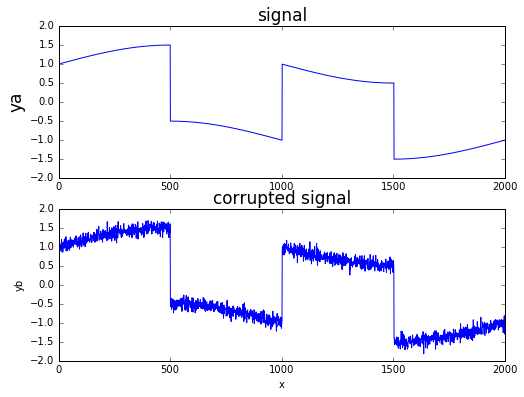

In [14]:
%matplotlib inline

n = 2000
t = [t_x for t_x in range(0,n)]
t = np.array(t)

exact = np.ones((2004,))
exact[0:501] = np.ones((501,))
exact[501:1002] = - np.ones((501,))
exact[1002:1503] = np.ones((501,))
exact[1503:2004] = - np.ones((501,))

x = exact[0:n] + 0.5*np.sin((2*np.pi/n)*t)
exact_varitation = np.sum(np.abs(exact[1:n] - exact[0:n-1]))


%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)

plt.subplot(2,1,1)
plt.plot(t,x)
plt.ylim([-2.0,2.0])
plt.title('signal' , fontsize = 17)
plt.ylabel('ya', fontsize = 17)

noise = 0.1*np.random.randn(t.shape[0])
corrupt = x + noise
noisy_variation = np.sum(np.abs(corrupt[1:n] - corrupt[0:n-1]))

plt.subplot(2,1,2)
plt.plot(t, corrupt)
plt.title('corrupted signal' , fontsize = 17)
plt.ylabel('yb')
plt.xlabel('x')
plt.show()

## Quadratic Smoothing ($L_2$ norm)

Populating the interactive namespace from numpy and matplotlib


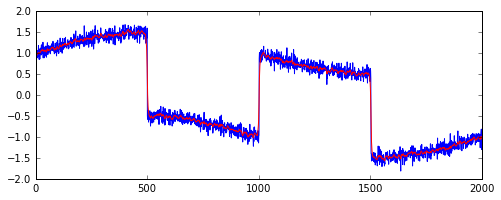

In [15]:
%matplotlib inline

beta = 1.2

x = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm2(x-corrupt))
constraint = [cvx.norm2(x[1:n]-x[0:n-1]) <= beta]
prob = cvx.Problem(objective, constraint)
result = prob.solve()

%pylab inline
pylab.rcParams['figure.figsize'] = (8, 3)

plt.plot(t, corrupt)
plt.plot(t, x.value, 'r')
plt.show()

- Quadratic smoothing smooths out _noise and sharp transitions_ in signal, but this is not what we want

- Any ideas ?

## $L_1$ Norm

We can instead apply total variation reconstruction on the signal by solving

$$\min \; \lVert x - x_{cor} \rVert_2 + \lambda \sum_{i=1}^{n-1} \;\lvert x_{i+1}-x_i \rvert $$

where the parameter lambda controls the ''smoothness'' of $x$.

Populating the interactive namespace from numpy and matplotlib


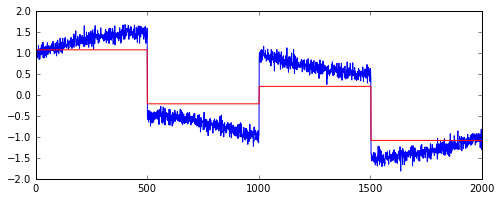

In [16]:
#CVX norm L2 with norm L1 constraints

def transition_plot(beta = 0.8):
    x = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm2(x-corrupt))
    constraint = [cvx.norm1(x[1:n]-x[0:n-1]) <= beta]
    prob = cvx.Problem(objective, constraint)
    result = prob.solve()

    %pylab inline
    pylab.rcParams['figure.figsize'] = (8, 3)

    plt.plot(t, corrupt)
    plt.plot(t, x.value, 'r')
    plt.show()

from IPython.html.widgets import interact
interact(transition_plot, beta=[2, 16, 1]);

- Total variation smoothing preserves sharp transitions in signal, and this is not bad

- Note how TV reconstruction does a better job of preserving the sharp transitions in the signal while removing the noise.


# 3. Total Variation Image Reconstruction

- idea comes from [here](http://www2.compute.dtu.dk/~pcha/mxTV/)

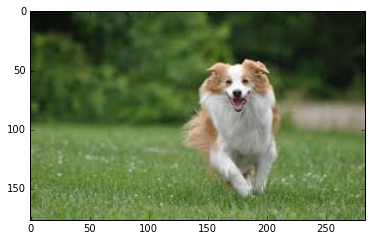

In [17]:
from scipy import stats, misc
%matplotlib inline

im = misc.imread('./image_files/dog.jpg')
plt.imshow(im)
plt.show()

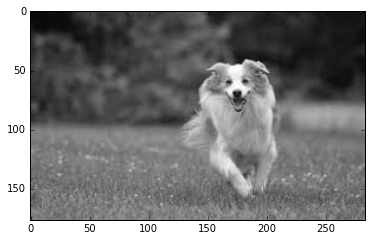

In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

imbw = rgb2gray(im)
plt.imshow(imbw, cmap = plt.get_cmap('gray'))
plt.show()

- Question: Apply $L_1$ norm to image, and guess what kind of an image will be produced ? 

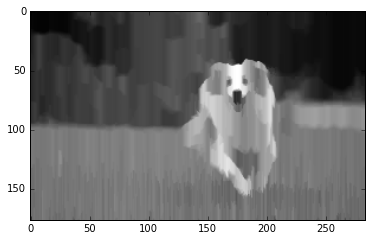

In [23]:
#cvx only can pyhon 2.7
%matplotlib inline
[row, col] = np.shape(imbw)
n = row*col

imbws = np.reshape(imbw, (n, 1), order='F')
beta = 70000

x = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm2(x-imbws))
constraint = [cvx.norm1(x[1:n] - x[0:n-1]) <= beta]
prob = cvx.Problem(objective, constraint)
result = prob.solve()

imbwr = np.reshape(x.value, (row, col), order = 'F')

plt.imshow(imbwr, cmap = plt.get_cmap('gray'))
plt.show()

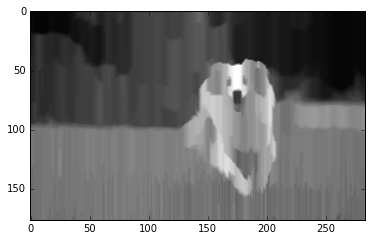

In [20]:
def image_plot(beta = 60000):
    [row, col] = np.shape(imbw)
    n = row*col
    imbws = np.reshape(imbw, (n, 1), order='F')

    x = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm2(x-imbws))
    constraint = [cvx.norm1(x[1:n] - x[0:n-1]) <= beta]
    prob = cvx.Problem(objective, constraint)
    result = prob.solve()

    imbwr = np.reshape(x.value, (row, col), order = 'F')


    plt.imshow(imbwr, cmap = plt.get_cmap('gray'))
    plt.show()
    
    
from IPython.html.widgets import interact
interact(image_plot, beta=[30000, 100000, 5000]);

- Cartoonish effect

# 4. Electric Power Consumption vs. Temperature

Data from [Seoul Open Data Plaza](http://data.seoul.go.kr/index.jsp)

In [14]:
[num_eletric,txt1] = xlsread([pwd,'\image_files\Excel_total.xls']);
[num_temperature,txt2] = xlsread([pwd,'\image_files\Excel_temp.xls']);

x = num_temperature(:,1);
y = num_eletric(:);
y = y/1000000;

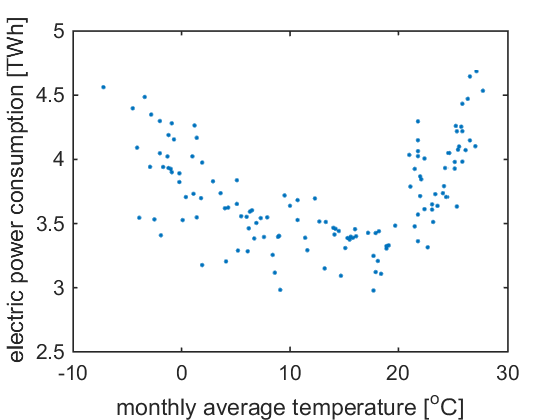

In [15]:
%plot -s 560,420
plot(x,y,'.')
xlabel('monthly average temperature [^oC]')
ylabel('electric power consumption [TWh]')

## polynomial functions


$$
\hat{y} = \theta_1 + \theta_2 x + \theta_3 x^2 + \cdots
$$

$$\phi(x) = \begin{bmatrix} 1 \\ x\\x^2 \\\vdots\end{bmatrix}$$

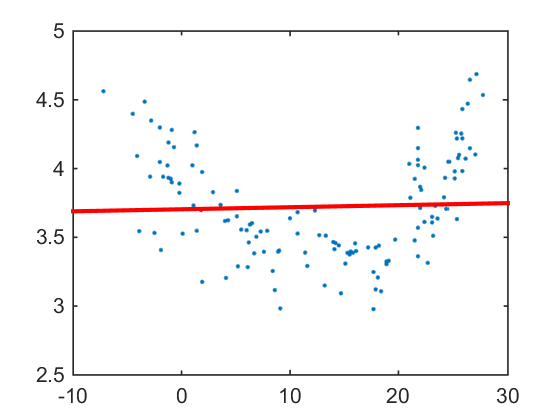

In [16]:
m = length(x);

xp = -10:0.1:30;
xp = xp(:);

d = 1;

Phi = [];
polybasis = [];

for i = 0:d
    Phi = [Phi x.^i];
    polybasis = [polybasis xp.^i];
end

theta = inv(Phi'*Phi)*Phi'*y;
yp = polybasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r','linewidth',2);  hold off

RSS = [];
yhat = Phi*theta;
RSS = [RSS norm(y-yhat,2)];

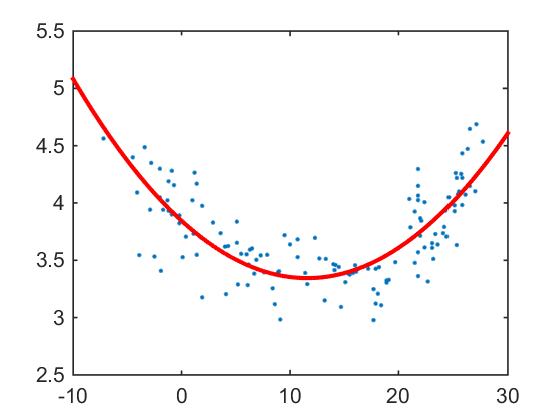

In [17]:
d = 2;

Phi = [];
polybasis = [];

for i = 0:d
    Phi = [Phi x.^i];
    polybasis = [polybasis xp.^i];
end

theta = inv(Phi'*Phi)*Phi'*y;
yp = polybasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r','linewidth',2);  hold off

e = [];
yhat = Phi*theta;
RSS = [RSS norm(y-yhat,2)];

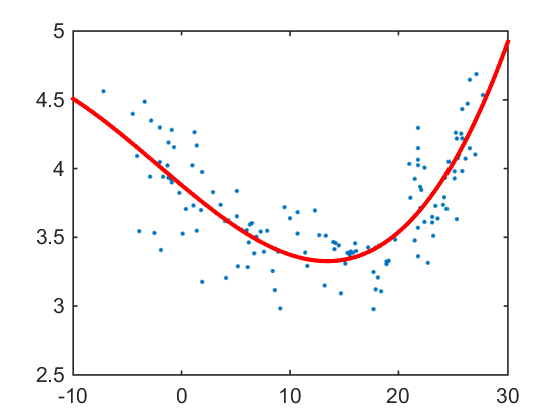

In [18]:
d = 3;

Phi = [];
polybasis = [];

for i = 0:d
    Phi = [Phi x.^i];
    polybasis = [polybasis xp.^i];
end

theta = inv(Phi'*Phi)*Phi'*y;
yp = polybasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r','linewidth',2);  hold off

yhat = Phi*theta;
RSS = [RSS norm(y-yhat,2)];

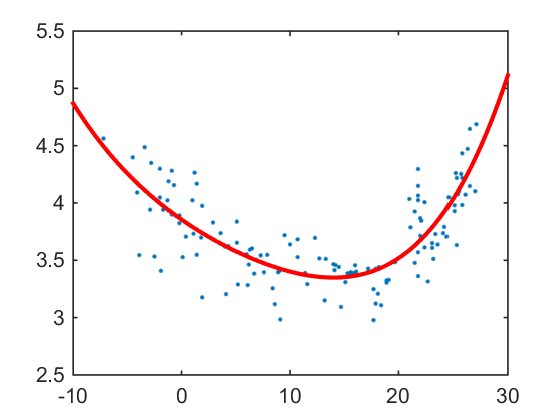

In [19]:
d = 4;

Phi = [];
polybasis = [];

for i = 0:d
    Phi = [Phi x.^i];
    polybasis = [polybasis xp.^i];
end

theta = inv(Phi'*Phi)*Phi'*y;
yp = polybasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r','linewidth',2);  hold off

yhat = Phi*theta;
RSS = [RSS norm(y-yhat,2)];

Question: How to decide a proper $d$

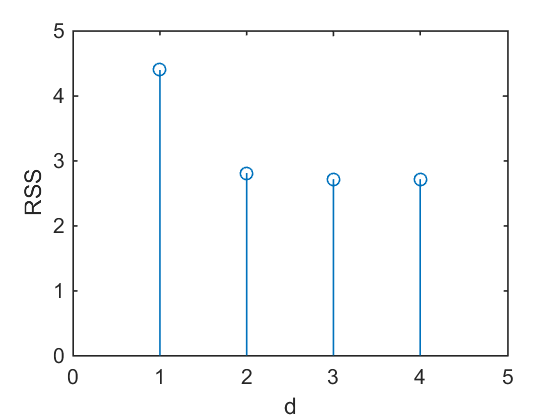

In [20]:
stem(RSS)
xlim([0 5])
xlabel('d')
ylabel('RSS')

If $d = 50$, See what is happening. Think about why. (numerical issue in computing matrix inverse)

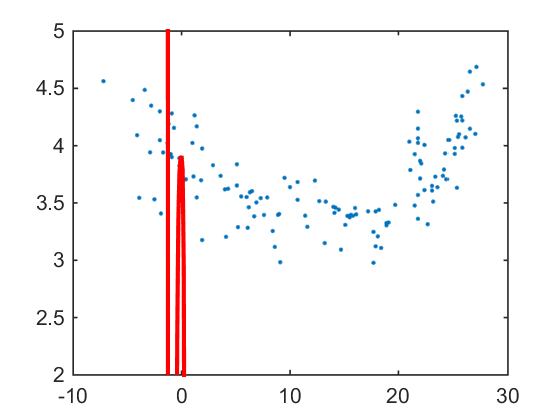

[Warning: Matrix is close to singular or badly scaled. Results may be inaccurate. RCOND = 3.768718e-144.] 
[  In pymat_eval at 35
  In matlabserver at 24]

In [21]:
d = 50;

Phi = [];
polybasis = [];

for i = 0:d
    Phi = [Phi x.^i];
    polybasis = [polybasis xp.^i];
end

theta = inv(Phi'*Phi)*Phi'*y;
yp = polybasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r','linewidth',2);  hold off

ylim([2 5])

Let's use CVX which utilizes the gradient descent method. (You do not need to know how CVX works inside)

- The below plot shows  __overfitting problems__

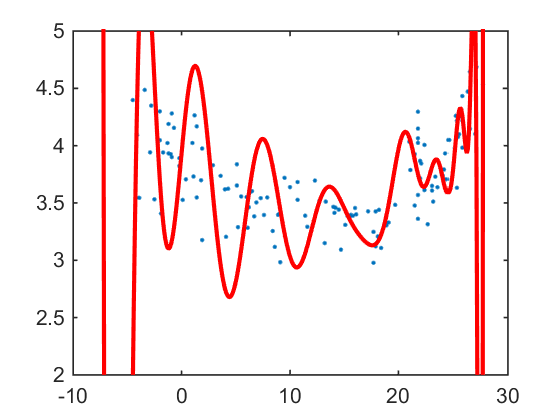

In [22]:
d = 50;

Phi = [];
polybasis = [];

for i = 0:d
    Phi = [Phi x.^i];
    polybasis = [polybasis xp.^i];
end

clear theta
cvx_begin quiet
    variable theta(d+1);
    minimize norm(Phi*theta-y,2)
cvx_end

yp = polybasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r','linewidth',2);  hold off
ylim([2 5])

## Use RBF function

- polynomial functions are not the only one
- Radial Basis Function (RBF) is also widely used
- RBF will be used to demonstrate how to overcome overfitting problems $\rightarrow$ regularization


Defined by bandwidth $\sigma$ and $k$ RBF centers $\mu_k \in \mathbb{R}^n$
$$ \phi_j(k) =  \exp \left( - \frac{\lVert x-\mu_j \rVert^2}{2\sigma^2}\right) $$

Linear Basis Function Models

Consider linear combinations of fixed nonlinear functions of the input variables, of the form

$$ \hat{y}=\sum{\theta_i \phi_i(x)} $$

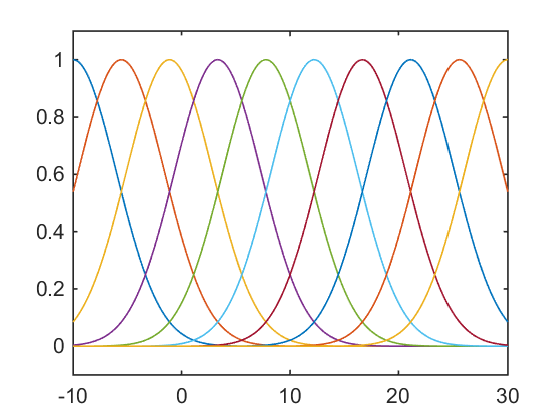

In [23]:
%% RBF basis
d = 10;
u = linspace(-10,30,d);

xp = (-10:0.1:30); xp = xp(:);

sigma = 4;

rbfbasis = [];
for j = 1:d
    rbfbasis = [rbfbasis exp(-(xp-u(j)).^2/(2*sigma^2))];
end

for i = 1:d
    plot(xp,rbfbasis(:,i)), hold on
end
hold off, ylim([-0.1 1.1])

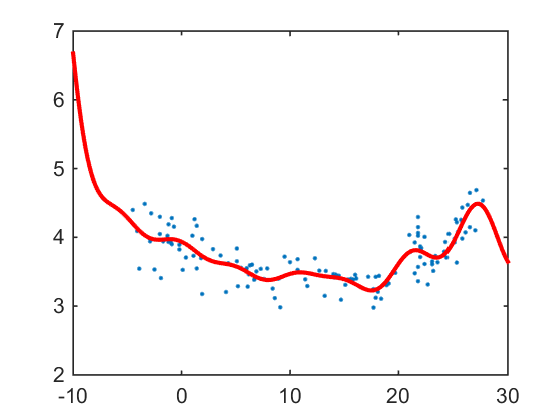

In [24]:
d = 50;
u = linspace(-10,30,d);
xp = (-10:0.1:30); xp = xp(:);

sigma = 4;

Phi = [];
rbfbasis = [];

for i = 1:d
    Phi = [Phi exp(-(x-u(i)).^2/(2*sigma^2))];
    rbfbasis = [rbfbasis exp(-(xp-u(i)).^2/(2*sigma^2))];
end

clear theta
cvx_begin quiet
    variable theta(d);
    minimize norm(Phi*theta-y,2)
cvx_end

yp = rbfbasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r-','linewidth',2);  hold off
%ylim([2 5])

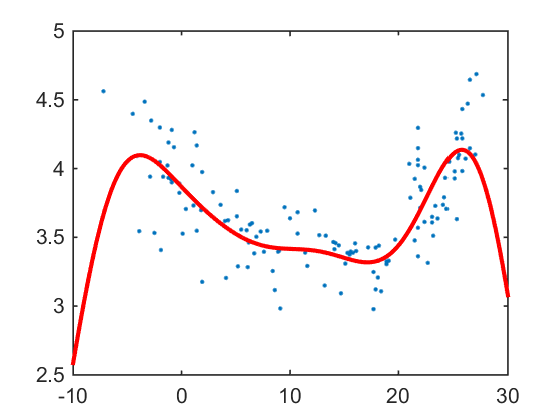

In [25]:
d = 50;
u = linspace(-10,30,d);
xp = (-10:0.1:30); xp = xp(:);

sigma = 4;

Phi = [];
rbfbasis = [];

for i = 1:d
    Phi = [Phi exp(-(x-u(i)).^2/(2*sigma^2))];
    rbfbasis = [rbfbasis exp(-(xp-u(i)).^2/(2*sigma^2))];
end

clear theta
lambda = 2;
cvx_begin quiet
    variable theta(d);    
    minimize sum_square(Phi*theta-y) + lambda*sum_square(theta)
cvx_end

yp = rbfbasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r-','linewidth',2);  hold off
%ylim([2 5])

Regulization ( = ridge nonlinear regression) encourage small weights, but not exactly 0

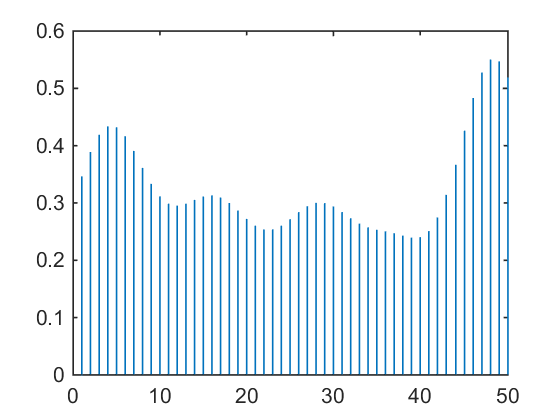

In [26]:
stem(theta,'marker','none')

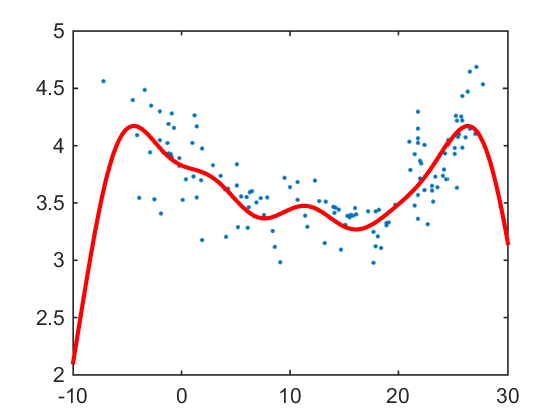

In [27]:
d = 50;
u = linspace(-10,30,d);
xp = (-10:0.1:30); xp = xp(:);

sigma = 4;

Phi = [];
rbfbasis = [];

for i = 1:d
    Phi = [Phi exp(-(x-u(i)).^2/(2*sigma^2))];
    rbfbasis = [rbfbasis exp(-(xp-u(i)).^2/(2*sigma^2))];
end

clear theta
lambda = 2;
cvx_begin quiet
    variable theta(d);    
    minimize sum_square(Phi*theta-y) + lambda*norm(theta,1)  
cvx_end

yp = rbfbasis*theta;

plot(x,y,'.'), hold on
plot(xp,yp,'r-','linewidth',2);  hold off
%ylim([2 5])

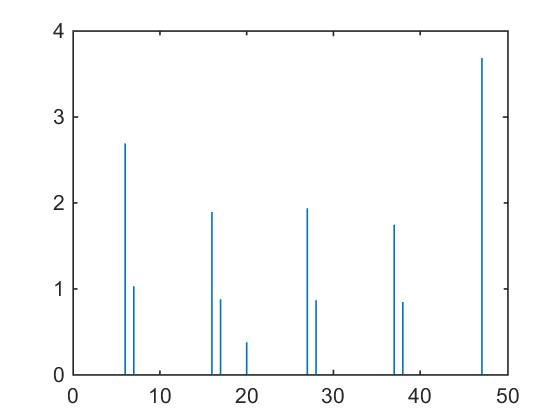

In [28]:
stem(theta,'marker','none')

In [29]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>